In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import math

import numpy as np
import datetime
from IPython.display import display
import pandas as pd

from garmindb import GarminConnectConfigManager
from garmindb.garmindb import GarminSummaryDb, DaysSummary, MonitoringDb, MonitoringHeartRate, Sleep, GarminDb
from garmindb.summarydb import DaysSummary, SummaryDb

from jupyter_funcs import format_number
from graphs import Graph

In [2]:
def minsFromTime(t):
    return float(t.hour * 3600 + t.minute * 60 + t.second) / 60.0

In [3]:
# start date
start_ts = datetime.datetime.combine(datetime.date(year=2022, month=5, day=1), datetime.datetime.min.time())
# end date (today)
end_ts = datetime.datetime.combine(datetime.date.today(), datetime.datetime.max.time())

gc_config = GarminConnectConfigManager()
db_params = gc_config.get_db_params()

garmin_db = GarminDb(db_params)
sum_db = SummaryDb(db_params, False)
data = DaysSummary.get_for_period(sum_db, start_ts, end_ts, DaysSummary)
sleep = Sleep.get_for_period(garmin_db, start_ts, end_ts)

time = [entry.day for entry in data]

In [4]:
stress_avg = [entry.stress_avg for entry in data]
bb_max = [entry.bb_max for entry in data]
bb_min = [entry.bb_min for entry in data]
rem_sleep_max = [minsFromTime(entry.rem_sleep_avg) for entry in data]
sleep_avg = [minsFromTime(entry.sleep_avg) / 60 for entry in data]
deep_sleep = [minsFromTime(sleep_event.deep_sleep) for sleep_event in sleep]
dm_df = pd.DataFrame([time, stress_avg, bb_max, bb_min, rem_sleep_max,deep_sleep, sleep_avg]).T
dm_df.columns = ["Date", "stress_avg", "bb_max", "bb_min", "rem_sleep_max", "deep_sleep", "sleep_avg"]
# remove the last record 'cause it's noisy sometimes
dm_df.drop(dm_df.tail(1).index,inplace=True)
# Filter out rows with NaN dates to prevent matplotlib errors
dm_df = dm_df.dropna(subset=["Date"]) 
dm_df



,Date,stress_avg,bb_max,bb_min,rem_sleep_max,deep_sleep,sleep_avg
0,2022-07-19,None,None,None,0.0,0.0,0.0
1,2022-07-23,None,None,None,0.0,0.0,0.0
2,2022-07-24,None,None,None,0.0,0.0,0.0
3,2022-07-25,None,None,None,0.0,0.0,0.0
4,2022-07-28,None,None,None,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1218,2025-12-23,17,94,33,135.0,87.0,8.128889
1219,2025-12-24,21,100,31,56.0,60.0,8.233333
1220,2025-12-25,23,83,31,48.0,103.0,6.339722
1221,2025-12-26,24,88,34,132.0,0.0,7.016667


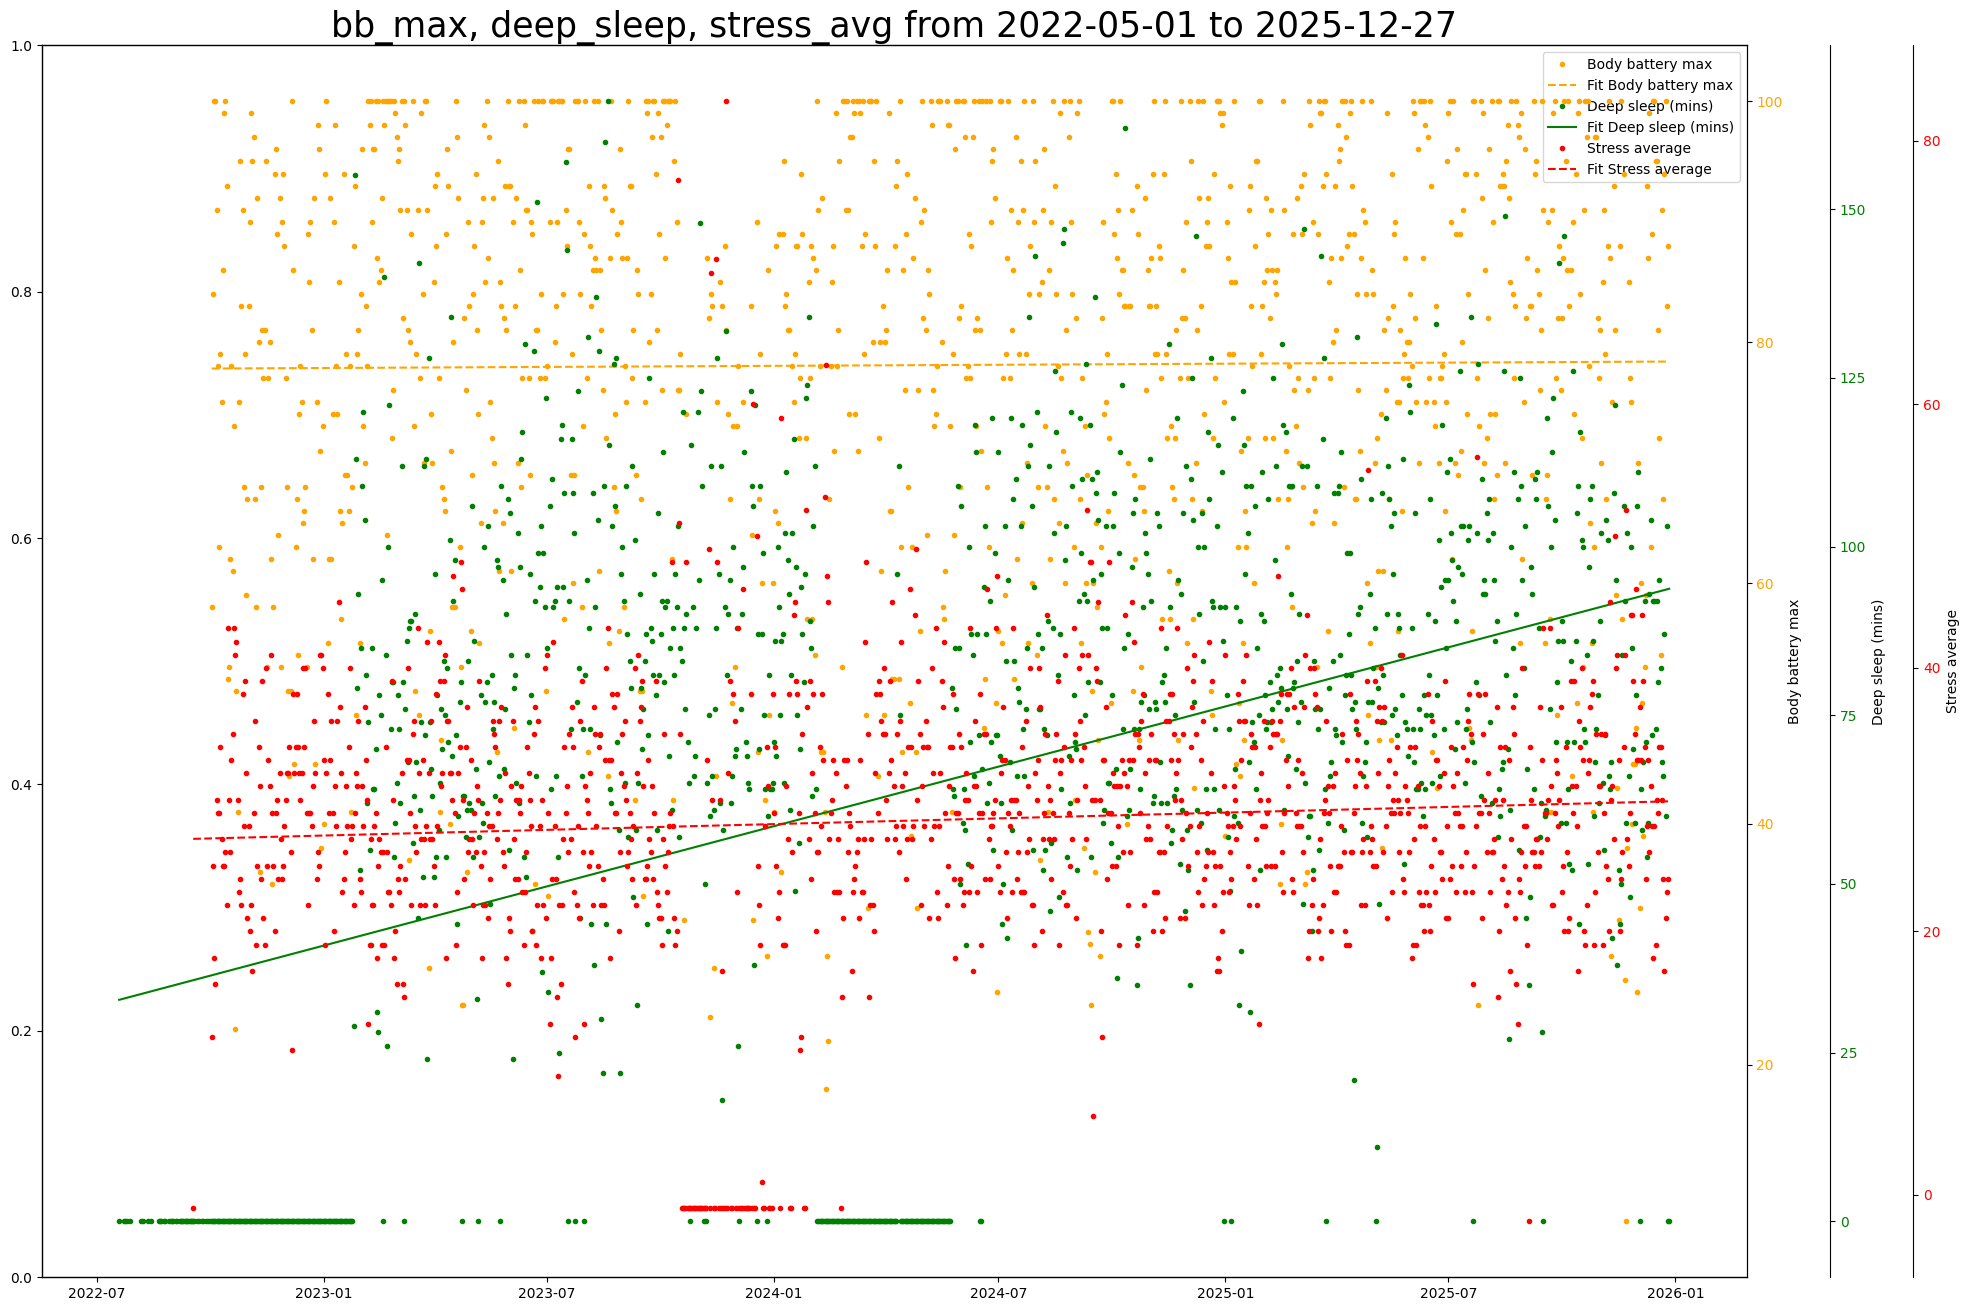

,,min,max
0,Fit Body battery max,77,78
1,Fit Deep sleep (mins),32,93
2,Fit Stress average,27,29


In [5]:


columns = { "stress_avg" : 
                   {
                       "label": "Stress average",
                       "trend_marker": "--",
                       "color": "red"

                   }, 
            "bb_max": 
                   {
                       "label": "Body battery max",
                       "trend_marker": "--",
                       "color": "orange"
                   },
           
            "sleep_avg": 
                   {
                       "label": "Sleep time (hrs)",
                       "trend_marker": "-.",
                       "color": "blue"
                  },
            "rem_sleep_max": 
                   {
                       "label": "Rem Sleep time (mins)",
                       "trend_marker": "-",
                       "color": "purple"
                   },
           
            "deep_sleep": 
                   {
                       "label": "Deep sleep (mins)",
                       "trend_marker": "-",
                       "color": "green"
                   }
          }

# these are the data columns to plot
show_cols = {"deep_sleep", "stress_avg", "bb_max"}

fig, host = plt.subplots(figsize=(22,16))

plots = []
fit_summary = []
step = 0

for col in show_cols:
    label=columns[col]["label"]
   
    ax2 = host.twinx()
    ax2.set_ylabel(label)
    ax2.tick_params(axis='y', labelcolor=columns[col]["color"])

    # Filter out NaN values for this column
    mask = dm_df[col].notna()
    plot_data = dm_df[mask]
    
    # data
    plot, = ax2.plot(plot_data.Date, plot_data[col], 'o', ms=3.0, color=columns[col]["color"], label=label)
    plots.append(plot)
    
    # trend
    fitlabel = 'Fit {}'.format(label)
    x_dates = dates.date2num(plot_data.Date)
    trend = np.polyfit(x_dates, plot_data[col].astype(float) , 1)
    fit = np.poly1d(trend)
    x_fit = np.linspace(x_dates.min(), x_dates.max()) if len(x_dates) > 0 else np.array([])
    fit, = ax2.plot(dates.num2date(x_fit), fit(x_fit), linestyle=columns[col]["trend_marker"], color=columns[col]["color"],label=fitlabel)
    plots.append(fit)
    
    ax2.spines['right'].set_position(('outward', step))
    
    step = step + 60

    fit_data = fit.get_ydata()
    
    fit_summary.append({"": fitlabel, "min": math.floor(fit_data.min()), "max":math.floor(fit_data.max())})
    
host.legend(handles=plots, loc='best')

col_label = ""
for col in show_cols:
    if len(col_label):
        col_label += ", "
    col_label += f"{col}"

title = f"{col_label} from {start_ts.date()} to {end_ts.date()}"

plt.title(label=title, fontsize=25)

plt.show()
pd.DataFrame(fit_summary)